# CSE 572: Lab 7

Cluster analysis seeks to partition the input data into groups of closely related instances so that instances that belong to the same cluster are more similar to each other than to instances that belong to other clusters. In this lab, you will practice implementing the K-means clustering technique. You can also explore Density-based and Hierarchical clustering technique optionally.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button.

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Load the dataset

We will start by loading the MNIST handwritten digits dataset. This dataset contains 8x8 grayscale images of handwritten digits from 0 to 9. Our goal in using clustering is to group images such that the handwritten digits on the images within each cluster are the same. Note: we do not split the dataset into train/val/test subsets because we are not doing classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
seed = 0
np.random.seed(seed)
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)

Print the number of samples and attributes in the dataset.

In [2]:
# print(f"Number of samples: {data.shape[0]}")
num_samples, num_attributes = data.shape
print(f"Number of samples: {num_samples}")
print(f"Number of attributes: {num_attributes}")

Number of samples: 1797
Number of attributes: 64


To get an idea of what is in our dataset, write code to visualize a random image from each class below.

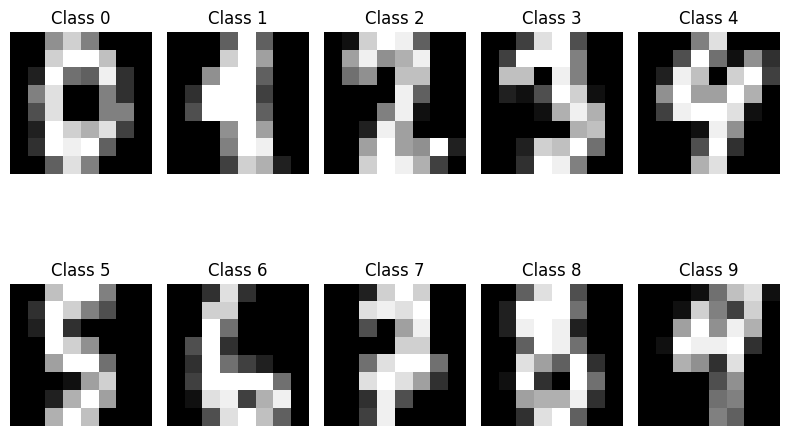

In [3]:
unique_classes = np.unique(labels)

plt.figure(figsize=(8, 6))
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]

    random_sample_index = np.random.choice(class_indices)
    image = data[random_sample_index].reshape(8, 8)

    plt.subplot(2, 5, class_label + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Class {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Next we standardize the data so that the mean of all attributes is 0 using the StandardScaler() class in scikit-learn to standardize the data.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

## K-means Clustering

The k-means clustering algorithm represents each cluster by its corresponding cluster centroid. The algorithm partitions the input data into *k* disjoint clusters by iteratively applying the following two steps:
1. Form *k* clusters by assigning each instance to its nearest centroid.
2. Recompute the centroid of each cluster.

We will first implement the standard K-means algorithm with randomly initialized centroids. We'll use 10 clusters because we have 10 classes and our goal is that each cluster contains mostly images from the same class.

In [5]:
from sklearn.cluster import KMeans

n_clusters = 10

k_means = KMeans(n_clusters=n_clusters, init='random', n_init=1, random_state=seed)
k_means.fit(data)

KMeans(init='random', n_clusters=10, n_init=1, random_state=0)

The `k_means.labels_` attribute contains the cluster labels assigned to each of our data samples. It is an array of integers representing the cluster number (starting from 0).

In [6]:
clusters = k_means.labels_

clusters

array([7, 1, 1, ..., 1, 8, 8], dtype=int32)

One way to evaluate how good our clustering was is to assess the homogeneity of classes in each cluster, since we know the class labels of this dataset. Below, we plot 10 examples randomly drawn from each of the 10 clusters. We plot the true class of each image in the title.

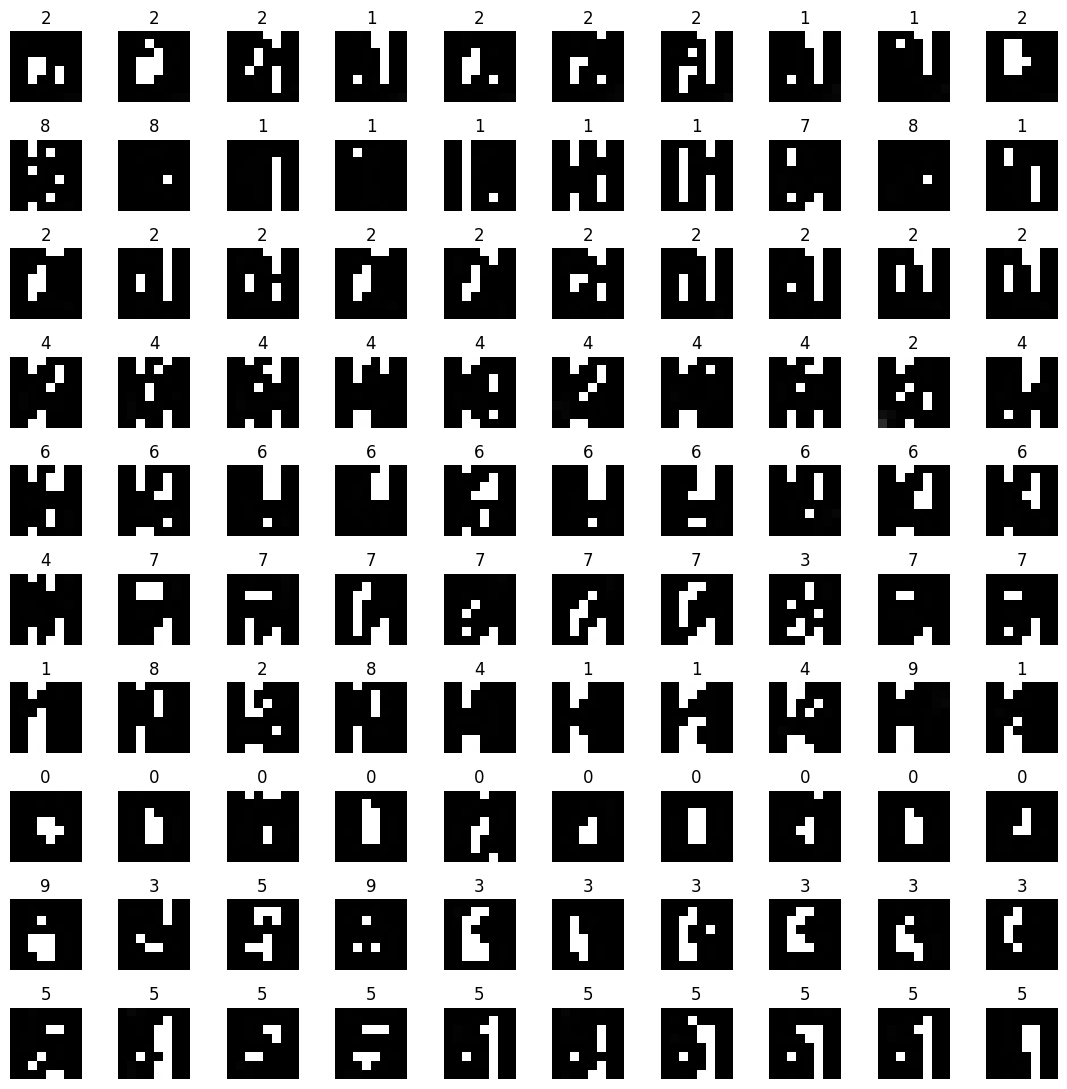

In [7]:
n_vis = 10
fig, axes = plt.subplots(ncols=n_vis, nrows=n_clusters, figsize=(11,11))

n_digits=10
data_rshp=data.reshape(len(data),8,8)
for i in range(n_digits):
    rand_inds = np.random.randint(0, clusters[clusters==i].shape[0], size=n_vis)
    for j in range(n_vis):
        axes[i,j].imshow(data_rshp[clusters==i][rand_inds[j]].astype(np.uint8), cmap='gray')
        axes[i,j].set_title(labels[clusters==i][rand_inds[j]])
        axes[i,j].axis('off')

fig.tight_layout()

Looking at the homogeneity of classes in these sample subsets, we can see that the clustering was not perfect but appears to be pretty good. We can quantify this using the homogeneity score.

A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

We compute the homogeneity score below.

In [8]:
from sklearn.metrics import homogeneity_score

kmeans_homog = homogeneity_score(labels, clusters)
print('K-means homogeneity score: %f' % kmeans_homog)

K-means homogeneity score: 0.665576


We can also evaluate multiple algorithms by comparing the "inertia" aka "cohesiveness" aka sum of squared errors of the points within each resulting cluster. This is stored in the `inertia_` attribute.

In [9]:
print('K-means inertia: %f' % k_means.inertia_)

K-means inertia: 70668.011798


## K-means++

K-means++ is a modified version of the K-means algorithm that chooses initial centroids to be far apart, instead of randomly choosing initial centroids. Read the [scikit-learn documentation for K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to figure out how to implement K-means++. Hint: this involves setting a specific argument.

Fit a K-means++ model for 10 clusters then compute the homogeneity score of the resulting clusters.

In [10]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=seed)
cluster_assignments = kmeans.fit_predict(data)

homogeneity = homogeneity_score(labels, cluster_assignments)

print(f"Homogeneity Score: {homogeneity}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Homogeneity Score: 0.6017212608396242


Additionally, print the inertia of the clustering resulting from K-means++.

In [11]:
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

Inertia: 69437.29782182128


## Choosing the number of clusters

In the previous examples, we used 10 clusters because we knew there were 10 classes in the dataset. However, in many use cases for clustering, we don't know which classes or how many classes are in the data, so we need a way of choosing the number of clusters to use.

To demonstrate these techniques, we will create a toy 2-dimensional dataset of blobs.

In [12]:
from sklearn.datasets import make_blobs
import numpy as np
seed = 1
np.random.seed(seed)
X, _ = make_blobs(n_samples=100, centers=np.random.randint(2, 11), n_features=2, random_state=seed)

Text(0, 0.5, 'x2')

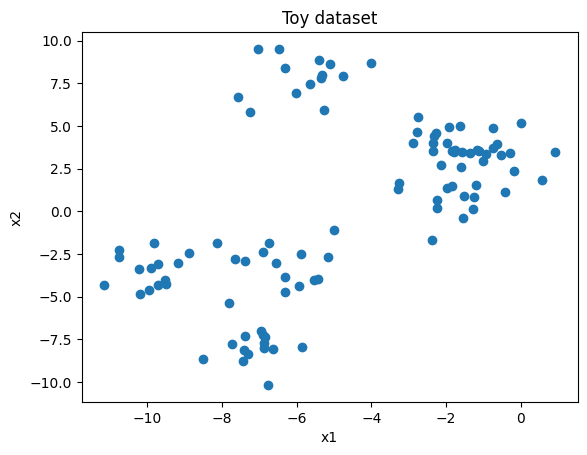

In [13]:
# Visualize the dataset

plt.scatter(X[:,0], X[:,1])
plt.title('Toy dataset')
plt.xlabel('x1')
plt.ylabel('x2')

**Question 1: How many clusters do you think is the ideal number of clusters for this dataset? Restrict your answer to numbers between 1 and 10.**

**Answer:**

5

To determine the number of clusters in the data, we can apply k-means with varying number of clusters from 1 to 10 and compute their corresponding sum-of-squared errors (SSE) as shown in the example below. The "elbow" in the plot of SSE versus number of clusters can be used to estimate the number of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'SSE')

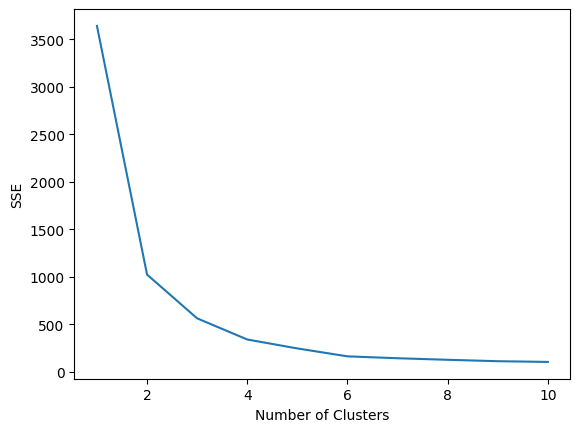

In [14]:
num_clusters = range(1, 11)
sse = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(num_clusters, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

Fit a K-means++ classifier to this dataset. Choose $k$ based on the "elbow" location in the plot above. Note that scikit-learn initializes centroids using the K-means++ algorithm by default, so this was used in the previous cell too. In practice, K-means is used to describe random and K-means++ initialization of centroids interchangeably, so we will continue referring to both as simply "K-means".

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

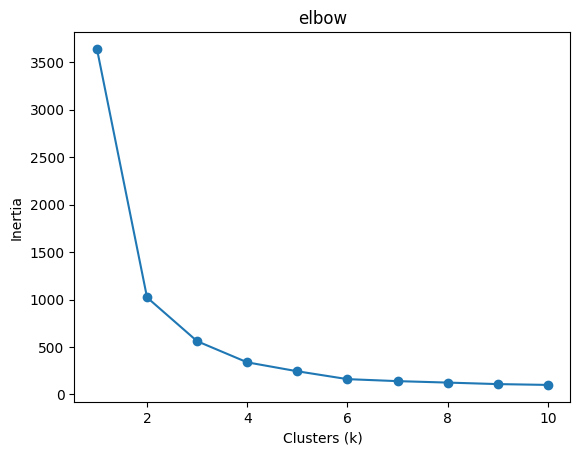

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ll = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++',  random_state=0)
    kmeans.fit(X)
    ll.append(kmeans.inertia_)

plt.plot(range(1, 11), ll, marker='o')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.title('elbow')
plt.show()

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(X)


Finally, plot the toy dataset colored by the resulting clusters.

Text(0, 0.5, 'x2')

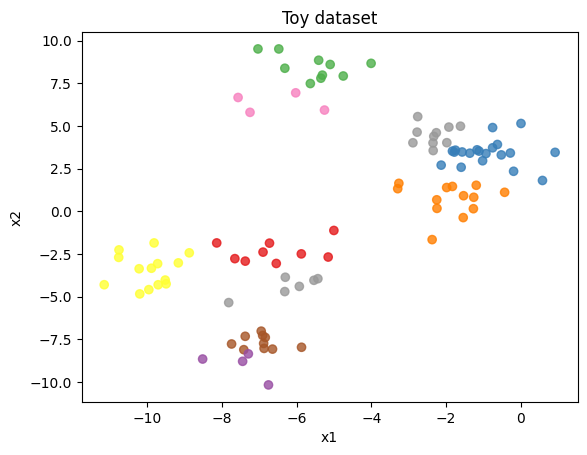

In [16]:
plt.scatter(X[:,0], X[:,1], alpha=0.8, c=kmeans.labels_, cmap='Set1')
plt.title('Toy dataset')
plt.xlabel('x1')
plt.ylabel('x2')

**Question 2: Was your guess from Question 1 the same as the number of clusters you chose based on the SSE plot? Why or why not?**

**Answer:**

In the first question, we estimated 5 clusters, but the actual number of clusters was different. The assumption of having k=5 clusters doesn't align with the SSE plot, which suggests k=10 clusters as optimal for this toy dataset. The challenge arises from overlapping data points and limited separation, making it difficult to accurately deduce the appropriate number of clusters visually, especially when considering noise or outliers. Additionally, the visual grouping of data into distinct clusters may introduce bias. It's crucial to rely on quantitative metrics like the SSE plot for a more objective determination of the optimal number of clusters.

## Agglomerative hierarchical clustering (Optional)

This section demonstrates examples of applying hierarchical clustering. Specifically, we illustrate the results of using 3 hierarchical clustering algorithms provided by the Python scipy library: (1) single link (MIN), (2) complete link (MAX), and (3) group average. Other hierarchical clustering algorithms provided by the library include centroid-based and Ward's method.

In [17]:
# Set the random seed
import numpy as np
np.random.seed(0)

### Load the dataset

The vertebrate dataset we will use in this lab consists of samples containing information about vertebrates. Each vertebrate is classified into one of 5 categories: mammals, reptiles, birds, fishes, and amphibians, based on a set of explanatory attributes (predictor variables). Except for "name", the rest of the attributes have been converted into a  binary representation.

In [18]:
import pandas as pd

data = pd.read_csv('https://docs.google.com/uc?export=download&id=1DrqbYx-0E8qdHexxO7m9fo11444pz5v5', header='infer')
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


In [19]:

names = data['Name']
Y = data['Class']
X = data.drop(['Name','Class'],axis=1)

### Single link (MIN) algorithm

The single link algorithm, also known as MIN, decides which clusters to merge by choosing the clusters with the smallest distance between any point from each of two clusters.

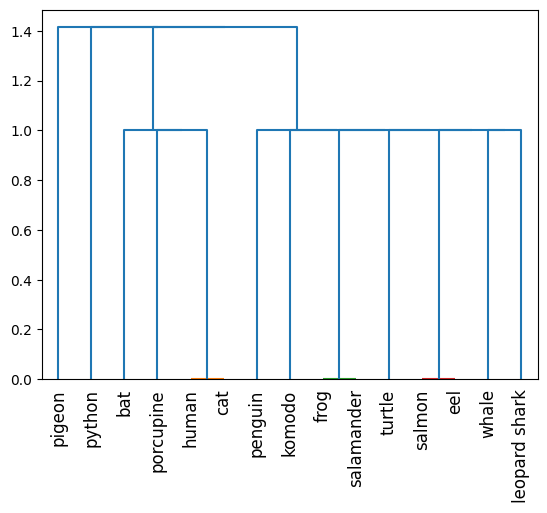

In [20]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

Z = hierarchy.linkage(X, 'single')
dn = hierarchy.dendrogram(Z, labels=names.tolist(), orientation='top', leaf_rotation=90)

**Question 1: What do the values on the x axis of the above dendrogram represent?**

**Answer:**
The horizontal line on the hierarchical clustering graph serves as a representation of the merging process of different clusters. It gauges the degree of similarity or dissimilarity between clusters as they combine. Each point along this line corresponds to an element under consideration. A lower position on the line indicates a higher similarity between clusters. Progressing along the line signifies the gradual merging of clusters, grouping them together if their proximity meets certain criteria. Ultimately, this process culminates in a single large cluster. The purpose of this line is to offer insights into the relationships among clusters as they form during the hierarchical clustering procedure.

### Complete link (MAX) algorithm

The complete link algorithm, also known as MAX, decides which clusters to merge by choosing the clusters with the smallest distance between the *farthest* pair of points from each of two clusters.

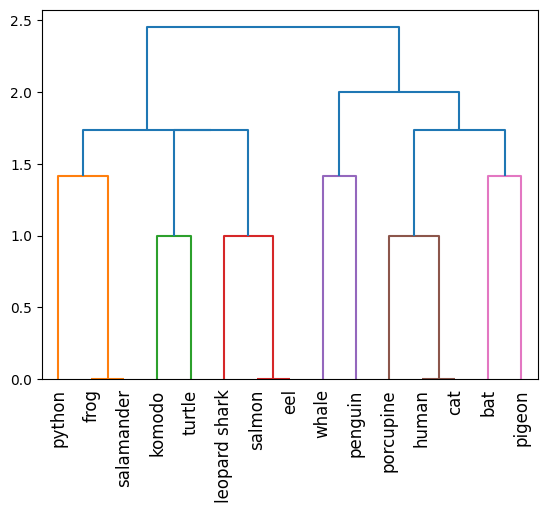

In [21]:
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z, labels=names.tolist(), orientation='top', leaf_rotation=90)

### Group average algorithm

**Question 2: How does the group average algorithm decide which clusters to merge?**

**Answer:** The group average algorithm decides which clusters to merge by comparing how similar clusters are to each other. It calculates the average similarity between all pairs of clusters, then merges the clusters that are most similar on average. This helps create cohesive merged clusters with data points that are closer or more alike.



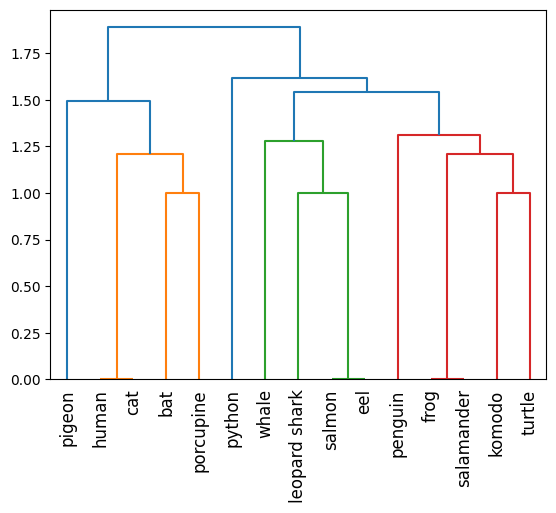

In [22]:
Z = hierarchy.linkage(X, 'average')
dn = hierarchy.dendrogram(Z, labels=names.tolist(), orientation='top', leaf_rotation=90)

## Density-Based Clustering (Optional)

Density-based clustering identifies the individual clusters as high-density regions that are separated by regions of low density. DBSCAN is one of the most popular density based clustering algorithms. In DBSCAN, data points are classified into 3 types---core points, border points, and noise points---based on the density of their local neighborhood. The local neighborhood density is defined according to 2 parameters:  radius of neighborhood size (eps) and minimum number of points in the neighborhood (min_samples).

For this approach, we will use a noisy, 2-dimensional dataset originally created by Karypis et al. [1] for evaluating their proposed CHAMELEON algorithm. The example code shown below will load and plot the distribution of the data.

[1] George Karypis, Eui-Hong Han, and Vipin Kumar. CHAMELEON: A Hierarchical Clustering Algorithm Using Dynamic Modeling. IEEE Computer 32(8): 68-75, 1999.

<Axes: xlabel='x', ylabel='y'>

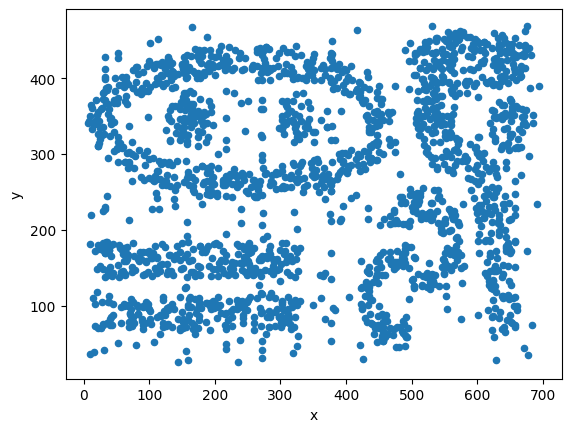

In [23]:
import pandas as pd
data = pd.read_csv('https://docs.google.com/uc?export=download&id=1GQNjiri37By8OzPEaETUfDGQhekjE82Z',
                   delimiter=' ',
                   names=['x', 'y'],
                   on_bad_lines='skip')

data.plot.scatter(x='x',y='y')

We apply the DBSCAN clustering algorithm on the data by setting the neighborhood radius (eps) to 15.5 and minimum number of points (min_samples) to be 5. The noise points are assigned to a cluster ID equal to -1 while the cluster IDs containing core points range from 0 to $k$ where $k$ is the number of resulting clusters.

In [24]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN model instance and fit it to our data
db = DBSCAN(eps=15.5, min_samples=5).fit(data)

# Create a pandas dataframe to store the resulting cluster IDs
clusters = pd.DataFrame(db.labels_, columns=['Cluster ID'])

# Combine the data and resulting clusters into one dataframe
results = pd.concat((data, clusters), axis=1)

results

,x,y,Cluster ID
0,650.914,214.888,4
1,41.767,179.408,0
2,509.126,233.749,1
3,486.403,152.427,2
4,46.883,367.904,3
...,...,...,...
1966,631.430,210.478,4
1967,187.652,247.923,3
1968,124.996,264.847,3
1969,522.511,302.785,4


Plot the dataset with points colored by their cluster ID (including noise points).

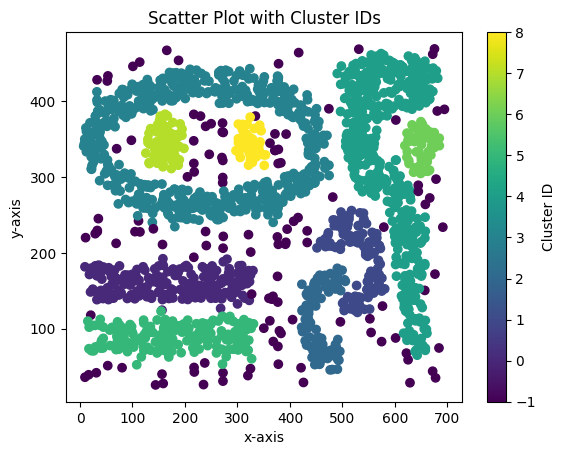

In [25]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

# Extracting data for visualization
x_values = results['x']
y_values = results['y']
cluster_ids = results['Cluster ID']

# Creating a scatter plot with distinct colors for each cluster
plt.scatter(results['x'], results['y'], c=results['Cluster ID'], cmap='viridis')

# Labeling the axes and providing a title
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Scatter Plot with Cluster IDs')

# Adding a colorbar to represent Cluster IDs
plt.colorbar(label='Cluster ID')

# Displaying the plot
plt.show()


**Question 3: How many clusters did DBSCAN find? (Do not count the noise points.)**

**Answer:**
9

In the cells below, use K-means to cluster the dataset. Set $k$ to be the same number of clusters found by DBSCAN. Use the default initialization for centroids (kmeans++).

In [26]:
# YOUR CODE HERE
from sklearn.cluster import KMeans
k = len(results['Cluster ID'].unique())
kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(data)
cluster_labels = kmeans.labels_
results['KMeans Cluster ID'] = cluster_labels
results

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,x,y,Cluster ID,KMeans Cluster ID
0,650.914,214.888,4,7
1,41.767,179.408,0,2
2,509.126,233.749,1,4
3,486.403,152.427,2,3
4,46.883,367.904,3,9
...,...,...,...,...
1966,631.430,210.478,4,7
1967,187.652,247.923,3,1
1968,124.996,264.847,3,9
1969,522.511,302.785,4,4


Next, plot the dataset colored by their cluster IDs chosen by K-means.

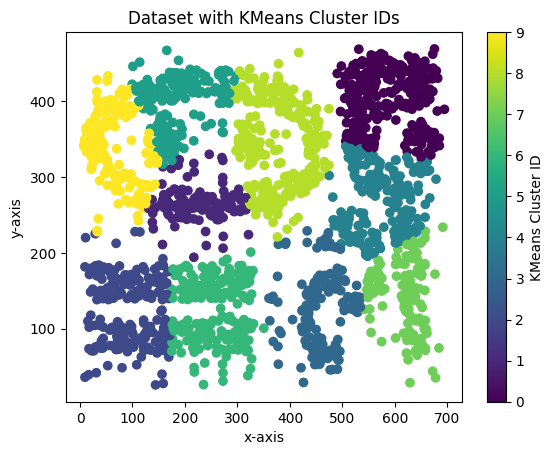

In [27]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

plt.scatter(results['x'], results['y'], c=results['KMeans Cluster ID'], cmap='viridis')

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Dataset with KMeans Cluster IDs')

plt.colorbar(label='KMeans Cluster ID')

plt.show()


**Question 4: Which clustering algorithm (DBSCAN or K-means) do you think resulted in a better clustering for this dataset?**

**Answer:**

DBSCAN is a clever algorithm that's great for finding clusters in data with different shapes and densities. Unlike K-means, it doesn't need us to guess the number of clusters beforehand, which is handy for our dataset. K-means tends to force every point into a cluster, even the ones far away from dense areas, while DBSCAN can recognize those as noise or outliers. It's like DBSCAN has a better sense of where the important groups are without being too strict.